# Setup Spark



In [1]:
# Remove any corrupted Spark archive
!rm -f spark-3.1.2-bin-hadoop2.7.tgz

# Download and extract Spark
!wget -q http://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

# Install Python dependencies
!pip install -q findspark
!pip install py4j

# Set SPARK_HOME environment variable
import os
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

# Initialize Spark with findspark
import findspark
findspark.init()

# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("CyberSecurityModeling").getOrCreate()


# Load Preprocessed Data

In [6]:
from google.colab import drive
drive.mount("/content/drive")

df = spark.read.parquet("/content/drive/MyDrive/preprocessed_balanced_data.parquet")

# Print current column names for reference
print("Column names:", df.columns)

df.printSchema()
df.show(5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Column names: ['Header_Length', 'Protocol_Type', 'Time_To_Live', 'Rate', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count', 'rst_count', 'DNS', 'TCP', 'UDP', 'ICMP', 'Tot_sum', 'Min', 'Max', 'AVG', 'Std', 'Tot_size', 'Label']
root
 |-- Header_Length: double (nullable = true)
 |-- Protocol_Type: long (nullable = true)
 |-- Time_To_Live: double (nullable = true)
 |-- Rate: double (nullable = true)
 |-- syn_flag_number: double (nullable = true)
 |-- rst_flag_number: double (nullable = true)
 |-- psh_flag_number: double (nullable = true)
 |-- ack_flag_number: double (nullable = true)
 |-- ack_count: double (nullable = true)
 |-- syn_count: double (nullable = true)
 |-- rst_count: double (nullable = true)
 |-- DNS: double (nullable = true)
 |-- TCP: double (nullable = true)
 |-- UDP: double (nullable = true)
 |-- 

# Encode Label

In [7]:
from pyspark.ml.feature import StringIndexer
label_indexer = StringIndexer(inputCol="Label", outputCol="label_index")
df = label_indexer.fit(df).transform(df)


# Create Feature Vector

In [8]:
from pyspark.ml.feature import VectorAssembler

# Automatically pick all feature columns (exclude Label columns)
feature_cols = [col for col in df.columns if col not in ["Label", "label_index"]]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# LOGISTIC REGRESSION


In [12]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Split the dataset into train and test
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

lr = LogisticRegression(featuresCol="features", labelCol="label_index", maxIter=20, regParam=0.1, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
lr_predictions = lr_model.transform(test_df)

evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")


Logistic Regression Accuracy: 0.5352


# RANDOM FOREST

In [13]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(featuresCol="features", labelCol="label_index", numTrees=50, maxDepth=5)
rf_model = rf.fit(train_df)
rf_predictions = rf_model.transform(test_df)

evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")


Random Forest Accuracy: 0.7579


# Sample And Convert To Pandas for XGBoost

In [14]:
sampled_df = df.select("features", "label_index").sample(fraction=0.1, seed=42).toPandas()
X = sampled_df["features"].apply(lambda x: x.toArray()).tolist()
y = sampled_df["label_index"]


# XGBOOST MODEL

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

xgb_model = XGBClassifier()
xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)
print("XGBoost Accuracy:", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))


XGBoost Accuracy: 0.8681988297017209
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6535
         1.0       0.49      0.84      0.62      6532
         2.0       0.69      0.34      0.46      6292
         3.0       0.75      0.53      0.62      6436
         4.0       0.71      0.89      0.79      6350
         5.0       1.00      1.00      1.00      6379
         6.0       0.70      0.55      0.62      6424
         7.0       0.64      0.82      0.72      6468
         8.0       0.86      0.65      0.74      6451
         9.0       1.00      1.00      1.00      6493
        10.0       1.00      1.00      1.00      6448
        11.0       1.00      1.00      1.00      6430
        12.0       1.00      1.00      1.00      6379
        13.0       1.00      1.00      1.00      6442
        14.0       1.00      1.00      1.00      6441
        15.0       1.00      1.00      1.00      6354
        16.0       1

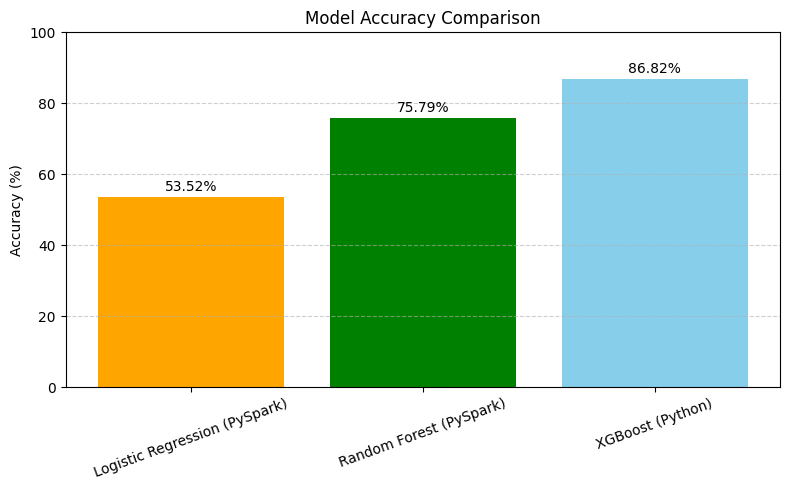

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")

# Logistic Regression Accuracy
lr_accuracy = evaluator.evaluate(lr_predictions)

# Random Forest Accuracy
rf_accuracy = evaluator.evaluate(rf_predictions)

# XGBoost Accuracy
xgb_accuracy = accuracy_score(y, y_pred)

# Combine & Plot

# Labels and accuracy values
models = ['Logistic Regression (PySpark)', 'Random Forest (PySpark)', 'XGBoost (Python)']
accuracies = [lr_accuracy * 100, rf_accuracy * 100, xgb_accuracy * 100]  # Convert to %

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['orange', 'green', 'skyblue'])

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.2f}%', ha='center', va='bottom')

# Format
plt.ylim(0, 100)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
